I've [previously
written](https://mlops.systems/fastai/redactionmodel/computervision/datalabelling/2021/09/06/redaction-classification-chapter-2.html)
about my use of fastai's `vision_learner` to create a classification model that
was pretty good (> 95% accuracy) at detecting whether an image contained
redactions or not.

This week in the course we switched domains and got to know HuggingFace's
[`transformers` library](https://github.com/huggingface/transformers) as a
pathway into NLP (natural language processing) which is all about text inputs. I
struggled quite a bit trying to think of interesting yet self-contained / small
uses of NLP that I could try out this week. A lot of the common uses for simple
NLP modelling seem to be in the area of things like 'sentiment analysis' where I
couldn't really see something I could build. Also there are a lot of NLP uses
cases which feel unethical or creepy (perhaps more so than in the computer
vision, it felt to me).

I emerged at the end of this thought process with the idea to try to pit image
classification and text classification against one another: could I train an NLP
model that would outperform my image classifier in detecting whether a specific
document or page contains a redaction or not?

Of course, the first thing I had to do was to OCR all the pages in my image
dataset and convert this all into a text dataset. When it comes to OCR tools,
there are a number of different options available and I'd luckily experimented
around with them. (A pretty useful overview of three leading options can be
found in [this
blogpost](https://francescopochetti.com/easyocr-vs-tesseract-vs-amazon-textract-an-ocr-engine-comparison/)
by Francesco Pochetti.) I went with Tesseract as I knew had pretty good
performance and accuracy for English-language documents.

My process for converting the documents wasn't particularly inspired.
Essentially I just loop over the image files one by one, run the OCR engine over
them to extract the text and then create a new `.txt` file with the extracted
text. At the end, I had two folders with my data, one containing texts whose
corresponding images I knew had contained redactions, and one where there were
no redactions.

I had two hunches that I hoped would help my NLP model.

1. I hoped that the redactions would maybe create some kind of noise in the
   extracted text that the training process could leverage to learn to
   distinguish redacted from unredacted.
2. I knew that certain kinds of subjects were more likely to warrant redaction
   than others, so perhaps even the noise of the OCR trying to deal with a
   missing chunk of the image wouldn't be as important as just grasping the
   contents of the document.

What follows is my attempt to follow steps initially outlined in Jeremy Howard's
[Kaggle
notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)
that the course reviewed this week in the live lesson. My code doesn't depart
from the original notebook much.

In [1]:
#| code-fold: true
!pip install datasets transformers tokenizers -Uqq

from pathlib import Path

import numpy as np
import pandas as pd

I save my `.txt` files on the machine and I get a list of all the paths of those files.

In [6]:
path = Path("redaction_texts")
p = path.glob("**/*.txt")
files = [x for x in p if x.is_file()]

I iterate through all the paths, making of list of all the redacted texts as strings.

In [7]:
texts = []
for file_path in files:
    with open(file_path) as file:
        texts.append(file.read())

In [8]:
!ls {path}

redacted   unredacted


## Converting text files into a Pandas DataFrame

I needed a way of obtaining the labels for my dataset. These labels were the
parent label for each path name. The training process below needed the labels to
be floats.

In [9]:
def is_redacted(path):
    "Extracts the label for a specific filepath"
    if str(path.parent).split("/")[-1] == "redacted":
        return float(1)
    else:
        return float(0)

is_redacted(files[1])

0.0

Converting a Python `dict` into a Pandas DataFrame is pretty simple as long as
you provide the data in the right formats. I had to play around with this a
little when I was getting this to work.

In [20]:
data = {
    "input": texts,
    "labels": [is_redacted(path) for path in files],
}

In [21]:
df = pd.DataFrame(columns=["input", "labels"], data=data)
# df

In [9]:
df.describe(include='object')

,input
count,3886
unique,3830
top,
freq,35


We now have a DataFrame containing 3886 rows of data. You can see here that 35
rows have no visible text. Potentially something went wrong with the OCR
extraction, or the redaction covered the entire image. I didn't really know or
want to fiddle around with that too much, so I left those rows in.

## Moving into HF Transformers Land

We create a `Dataset` object from our DataFrame. It requires that our targets
have the column name `labels`.

In [12]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

In [13]:
ds

Dataset({
    features: ['input', 'labels'],
    num_rows: 3886
})

We're finetuning a pre-trained model here, so I start with the small version of
Deberta which will allow me (I hope!) to iterate quickly and come up with an
initial baseline and sense of whether this is even a viable approach to solving
the problem.

In [14]:
model_nm = 'microsoft/deberta-v3-small'

Before we finetune our model, we have to do two things to our text data in order
that it works within our gradient descent powered training process:

- we have to tokenise our text data
- we have to turn those tokens into numbers so they can be crunched within our
  GPU as numbers.

Tokenisation is the process of splitting our words into shorter stubs of text --
there are varying schools of thought and use cases on the extent to which you
break the words down. We have to use the same tokenisation process that was used
by our pretrained model, so we let `transformers` grab the original tokenisers
that was used with `deberta-v3-small`.

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
def tok_func(x): return tokz(x["input"])

In [17]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

We split our data into training and validation subsets as per usual so that we
know how our model is doing while training.

In [18]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['input', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2914
    })
    test: Dataset({
        features: ['input', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 972
    })
})

We define our metric as Pearson's `r` AKA [the Pearson correlation
coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), a
metric I don't feel an immense instinctual understanding for, but suffice it for
this blogpost to know that a higher value (up to a maximum of 1) is better.

In [19]:
def corr(x, y):
    return np.corrcoef(x, y)[0][1]


def corr_d(eval_pred):
    return {"pearson": corr(*eval_pred)}

In [20]:
from transformers import TrainingArguments,Trainer

Here we define our batch size, the number of epochs we want to train for as well
as the learning rate. The defaults in Jeremy's NLP notebook were far higher than
what you see here. His batch size was 128. When I ran the cells that follow, I
hit the infamous "CUDA out of memory" error more or less immediately. I was
running on a machine with a 16GB RAM GPU, but this apparently wasn't enough and
the batch size was **far** too large. I had to reduce it down to 4, as you can
see, in order to even be able to train the model. There are tradeoffs to this in
terms of how well the model learns, but without spending lots of money on fancy
machines this was the compromise I had to make.

In [21]:
bs = 4
epochs = 5
lr = 1e-4

In [22]:
args = TrainingArguments(
    "outputs",
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    fp16=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs * 2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    report_to="none",
)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_nm, num_labels=1
)
trainer = Trainer(
    model,
    args,
    train_dataset=dds["train"],
    eval_dataset=dds["test"],
    tokenizer=tokz,
    compute_metrics=corr_d,
)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [24]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: input. If input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2914
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 3645


Epoch,Training Loss,Validation Loss,Pearson
1,0.250100,0.168366,0.705429
2,0.171600,0.134761,0.748499
3,0.118200,0.114869,0.784274
4,0.089600,0.093946,0.818484
5,0.063100,0.091717,0.822977


Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: input. If input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 972
  Batch size = 8
Saving model checkpoint to outputs/checkpoint-1000
Configuration saved in outputs/checkpoint-1000/config.json
Model weights saved in outputs/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-1000/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-1000/special_tokens_map.json
The foll

At the end of all this, we have a Pearson's score of 0.82 on our validation set
which doesn't seem to be as good as our image classifier. I'm not sure how I
would go about comparing these two different metrics. I imagine I'd want to
ensure that both my metrics were identical to make a like-for-like comparison.

My model is available on the Huggingface Hub
[here](https://huggingface.co/strickvl/nlp-redaction-classifier).

## What did I learn?

- Training NLP models feels like a bit of a different world from that of
  computer vision. There are different constraints in the process that I wasn't
  previously aware of and working with the `transformers` library exposed me to
  a bunch of new errors and hoops I had to jump through.
- It seems that the RAM needed on the GPU is directly correlated with the length
  of the text documents. Mine were on the long-ish end of the scale
  (particularly when compared with tweets which was what Jeremy was training on
  in his notebook). I wonder how people solve this problem, since mine by were
  by no means incredibly long.
- NLP models take longer to train than computer vision models; at least, the
  transformer-based models that I was working with.
- It's hard to compare two models together that don't share the same metric or
  loss function.
- There are MANY fiddly knobs to twist with NLP, particularly around the
  pre-processing of text samples, tokenisation strategies and so on. I wonder
  how much of those will be abstracted away from the high-level fastai
  abstraction when the library integrates with `transformers` in the coming
  months.
- The end-to-end process is *broadly* the same, however, and it was good to have
  the foundation that we've been building up over the previous weeks in the
  course.

The next model I train hopefully will not be relating to redactions, I promise!

UPDATE: I read a bit in the new O'Reilly book by the `transformers` team,
[*Natural Language Processing with Transformers*](https://transformersbook.com),
which seems to address the issue of the same text size:

> "Transformer models have a maximum input sequence length that is referred to
> as the *maximum context size*. For applications using DistilBERT, the maximum
> context size is 512 tokens, which amounts to a few paragraphs of text. [...]
> Texts that are longer than a model's context size need to be truncated, which
> can lead to a loss in performance if the truncated text contains crucial
> information." (pages 28-29 of the paperback edition)

The book suggests plotting out the number of tokens to get a sense of the
distribution of the data by size:

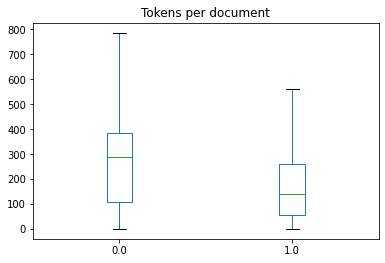

In [23]:
import matplotlib.pyplot as plt

df["Tokens per document"] = df["input"].apply(lambda x: len(x.split()))
df.boxplot(
    "Tokens per document",
    by="labels",
    grid=False,
    showfliers=False,
)
plt.suptitle("")
plt.xlabel("")
plt.show()

Here we can see that we have a fairly wide distribution, with quite a few texts
going all the way up to 800 tokens in length, so that is probably responsible
for the large amounts of RAM needed, but perhaps the truncation of texts is also
harming our performance.

When I visit [the `deberta-v3-small` model
card](https://huggingface.co/microsoft/deberta-v3-small) on Huggingface, I also
see reference to a maximum sequence length of 256 which would indeed harm my
model and its ability to learn, I reckon.